<a href="https://colab.research.google.com/github/AimanAminuddin/Function-Image-Reconstruction-/blob/main/Week_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import jax 
from jax.config import config
config.update('jax_enable_x64', True)  # often needed for LBFGS that requires high-precision


import jax.numpy as jnp
import numpy as np
import pylab as plt

import imageio
import os
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import time
import scipy

## Exercise: Gaussian Posterior Distribution (theory)

Consider a prior distribution on $\beta \in \mathbb{R}^p$ given by 
$$\pi_0(\beta) \; \propto \; N(0, \tau^2 \, I_p).$$
For a design matrix $X \in \mathbb{R}^{n,p}$ we observe data $Y$ distributed as
$$y \; \sim \; X \beta + N(0, \sigma^2 \, I_n)$$
Find the MAP estimate of $\beta$

Working 
---


The likelihood function is 
\begin{equation}
P(y|\beta) = \frac{1}{\sqrt{(2\pi\sigma^{2})^{n}}}\exp(-\frac{1}{2\sigma^{2}}\|y-X\beta\|_{2}^{2})
\end{equation}
The density function of the prior is 
\begin{equation}
\frac{1}{\sqrt{(2\pi\tau^{2})^{p}}}\exp(-\frac{1}{2\tau^{2}}\|\beta\|_{2}^{2})
\end{equation}
Hene, the posteror distribution of $\beta$ is 
\begin{equation}
\pi(\beta) \propto \exp(-\frac{1}{2\sigma^{2}}\|y-X\beta\|_{2}^{2}-\frac{1}{2\tau^{2}}\|\beta\|_{2}^{2})
\end{equation}


---

To find the MAP estimate of $\beta$ let $J(\beta) = -\frac{1}{2\sigma^{2}}\|y-X\beta\|_{2}^{2}-\frac{1}{2\tau^{2}}\|\beta\|_{2}^{2}$. Then, 
\begin{equation}
\nabla J(\beta) = -\frac{1}{\sigma^{2}}X^{T}(X\beta-y)-\frac{1}{\tau^{2}}\beta = 0 
\end{equation}

We solve 
\begin{align}
\tau^{2}X^{T}(X\beta-y) + \sigma^{2}\beta &= 0 \\ 
(\tau^{2}X^{T}X+\sigma^{2}I_{n})\beta &= \tau^{2}X^{T}Y \\ 
\beta^{*} &= (X^{T}X+\frac{\sigma^{2}}{\tau^{2}}I_{n})^{-1}X^{T}Y \\ 
\end{align}
Hence, $\beta^{*}$ is the MAP estimate of $\beta$. 


## Exercise: Poisson reconstruction (theory + coding)

Data points $\{y_i\}_{i=1}^{100}$ distributed as 
$$y_i = \mathbf{Poisson}( F(x_i) )$$

are collected where $\{x_i\}_{i=1}^{100}$ are known values 

$$-10 = x_1 < x_2 < \ldots < x_{100} = 10$$

and $F: \mathbb{R} \to (0,\infty)$ is an unkown function. Find a way to reconstruct an approximation of this unkown function from the observations $\{y_i\}_{i=1}^{100}$ and $\{x_i\}_{i=1}^{100}$

In [ ]:
x_list = np.linspace(-10,10,100)
truth_list = 3 + 2*jnp.sin(x_list)  # unkown function 
y_list = np.random.poisson(lam=truth_list)

**Construct a function from the data points generated**

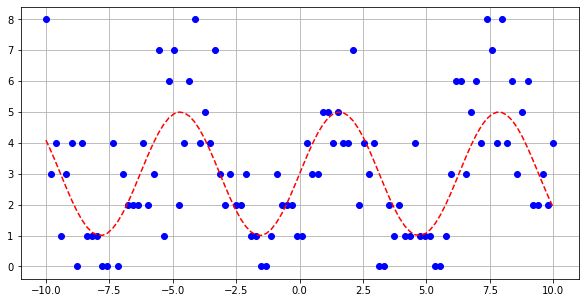

In [ ]:
# Using Numpy to reconstruct the unknown function 
plt.figure(figsize=(10,5))
plt.plot(x_list, y_list, "bo")
plt.plot(x_list, truth_list, "r--")
plt.grid(True)


**Function Reconstruction from scratch**

In [ ]:
z = np.random.normal(0,1,size=len(y_list))

In [ ]:
# z may be negative, we reparametrized z such that 
# z is positive 
def loglikelihood(w):
  z = jnp.exp(w)
  return jnp.mean(y_list * jnp.log(z)-z)

def l2_regularization(w):
  z = jnp.exp(w)
  l = 1.
  return l * jnp.mean((z[1:]-z[:-1])**2)

def loss(w):
  return -loglikelihood(w) + l2_regularization(w) 

loss_value_grad = jax.jit(jax.value_and_grad(loss))

In [ ]:
# perform gradient descent to find optimal z 

iter = 500
learning_rate = 0.9
loss_history = []
z0 = z.copy()

for _ in range(iter):
  value,gradient = loss_value_grad(z0) 
  z0 -= learning_rate * gradient 
  loss_history.append(value)


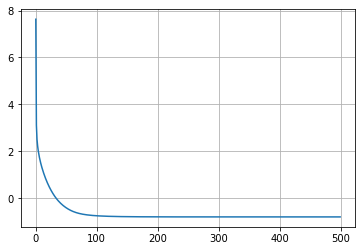

In [ ]:
plt.plot(loss_history)
plt.grid(True)

In [ ]:
w = jnp.exp(z0)

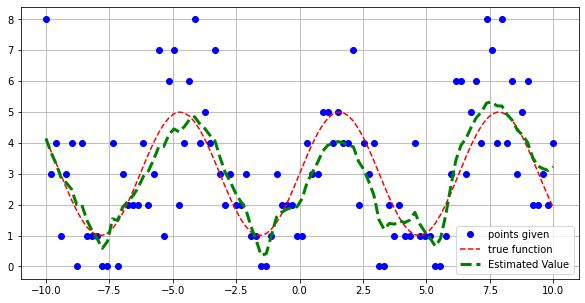

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(x_list, y_list, "bo")
plt.plot(x_list, truth_list, "r--")
plt.plot(x_list,w,"g--",lw = 3)
plt.legend(["points given","true function","Estimated Value"])
plt.grid(True)